In [119]:
import numpy as np
import matplotlib.pyplot as plt

class RBFNN:
    def __init__(self, node_number, sigma=1.0, eta=0.01, position=1, random_state=False):
        self.node_number = node_number
        self.sigma = sigma
        self.eta = eta  
        self.node_positions = None
        self.weights = None
        self.kernel_matrix = None
        self.training_errors = []
        self.random_state = random_state
        self.position = position  

    def get_node_positions(self, X):
        if self.random_state:
            self.node_positions = np.random.uniform(X.min(axis=0), X.max(axis=0), (self.node_number, X.shape[1]))
        else:
            self.node_positions = np.linspace(X.min(axis=0), X.max(axis=0), self.node_number).reshape(self.node_number, -1)

    def competitive_learning(self, X, num_nodes, learning_rate=0.5, epochs=1000):
        node_positions = X[np.random.choice(X.shape[0], num_nodes, replace=False)]
        for epoch in range(epochs):
            for x in X:
                distances = np.linalg.norm(node_positions - x, axis=1)
                closest_idx = np.argmin(distances)
                node_positions[closest_idx] += learning_rate * (x - node_positions[closest_idx])
        return node_positions

    def competitive_learning_beta(self, X, num_nodes, num_winners=3, learning_rate=0.5, epochs=100):
        node_positions = X[np.random.choice(X.shape[0], num_nodes, replace=False)]
        for epoch in range(epochs):
            for x in X:
                distances = np.linalg.norm(node_positions - x, axis=1)
                closest_indices = np.argsort(distances)[:num_winners]
                for i, idx in enumerate(closest_indices):
                    update_factor = learning_rate * (1 - i / num_winners)
                    node_positions[idx] += update_factor * (x - node_positions[idx])
        return node_positions

    def RBF_function(self, x, node_position):
        return np.exp(-np.linalg.norm(x - node_position, axis=-1)**2 / (2 * self.sigma**2))

    def get_kernel_matrix(self, X):
        kernel_matrix = np.zeros((len(X), self.node_number))
        for i in range(len(X)):
            kernel_matrix[i, :] = np.array([self.RBF_function(X[i], node_position) for node_position in self.node_positions])
        return kernel_matrix

    def fit_batch(self, X, Y):
        if self.node_positions is None:
            if self.position == 1:
                self.get_node_positions(X)
            elif self.position == 2:
                self.node_positions = self.competitive_learning(X, self.node_number, learning_rate=0.1, epochs=500)
            elif self.position == 3:
                self.node_positions = self.competitive_learning_beta(X, self.node_number, num_winners=3, learning_rate=0.1, epochs=500)

        self.kernel_matrix = self.get_kernel_matrix(X)
        self.weights, _, _, _ = np.linalg.lstsq(self.kernel_matrix, Y, rcond=None)

    def fit_online(self, X, Y, epochs=100):
        if self.node_positions is None:
            if self.position == 1:
                self.get_node_positions(X)
            elif self.position == 2:
                self.node_positions = self.competitive_learning(X, self.node_number, learning_rate=0.1, epochs=500)
            elif self.position == 3:
                self.node_positions = self.competitive_learning_beta(X, self.node_number, num_winners=3, learning_rate=0.1, epochs=500)

        self.weights = np.random.randn(self.node_number, Y.shape[1])  # 这里支持 Y 是多维的
        self.training_errors = []

        for epoch in range(epochs):
            total_error = 0
            for i in range(len(X)):
                phi_x = np.array([self.RBF_function(X[i], node_position) for node_position in self.node_positions])
                y_pred = np.dot(phi_x, self.weights)
                error = Y[i] - y_pred
                self.weights += self.eta * error[:, np.newaxis] * phi_x  # 确保维度匹配
                total_error += np.abs(error).sum()
            if (epoch + 1) % 10 == 0:
                self.training_errors.append(total_error / len(X))

    def predict(self, X_test):
        kernel_test = self.get_kernel_matrix(X_test)
        return np.dot(kernel_test, self.weights)  # 这里自动适配多维 Y


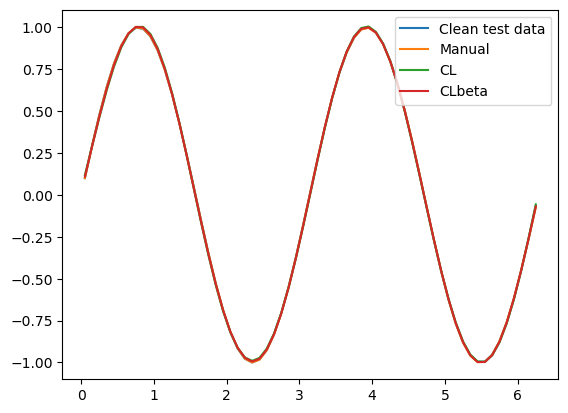

MAE Manual: 0.0014598133925511412
MAE CL: 0.0065396464356223885
MAE CLbeta: 0.0035621925532978212


In [120]:
noise_variance = 0.1
eta = 0.01

X_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1)
sin_Y_train_clean = np.sin(2 * X_train).reshape(-1, 1)
sin_Y_train_noisy = sin_Y_train_clean + np.random.normal(0, np.sqrt(noise_variance), X_train.shape)
X_test = np.arange(0.05, 2 * np.pi, 0.1).reshape(-1, 1)
sin_Y_test_clean = np.sin(2 * X_test).reshape(-1, 1)

node_number = 10
sigma = 1
# uniform initialization
position = 1
rbf_manual = RBFNN(node_number, sigma,eta, position)
rbf_manual.fit_batch(X_train, sin_Y_train_clean)
Y_pred_manual = rbf_manual.predict(X_test)
error_manual_MAE = np.mean(np.abs(Y_pred_manual - sin_Y_test_clean))

# CL
position = 2
rbf_CL = RBFNN(node_number, sigma,eta, position)
rbf_CL.fit_batch(X_train, sin_Y_train_clean)
Y_pred_CL = rbf_CL.predict(X_test)
error_CL_MAE = np.mean(np.abs(Y_pred_CL - sin_Y_test_clean))


# CLbeta
position = 2
rbf_CLbeta = RBFNN(node_number, sigma,eta, position)
rbf_CLbeta.fit_batch(X_train, sin_Y_train_clean)
Y_pred_CLbeta = rbf_CLbeta.predict(X_test)
error_CLbeta_MAE = np.mean(np.abs(Y_pred_CLbeta - sin_Y_test_clean))

plt.figure()
plt.plot(X_test, sin_Y_test_clean, label='Clean test data')
plt.plot(X_test, Y_pred_manual, label='Manual')
plt.plot(X_test, Y_pred_CL, label='CL')
plt.plot(X_test, Y_pred_CLbeta, label='CLbeta')
plt.legend()
plt.show()
print('MAE Manual:', error_manual_MAE)
print('MAE CL:', error_CL_MAE)
print('MAE CLbeta:', error_CLbeta_MAE)


Error CL: 0.006236883601093216


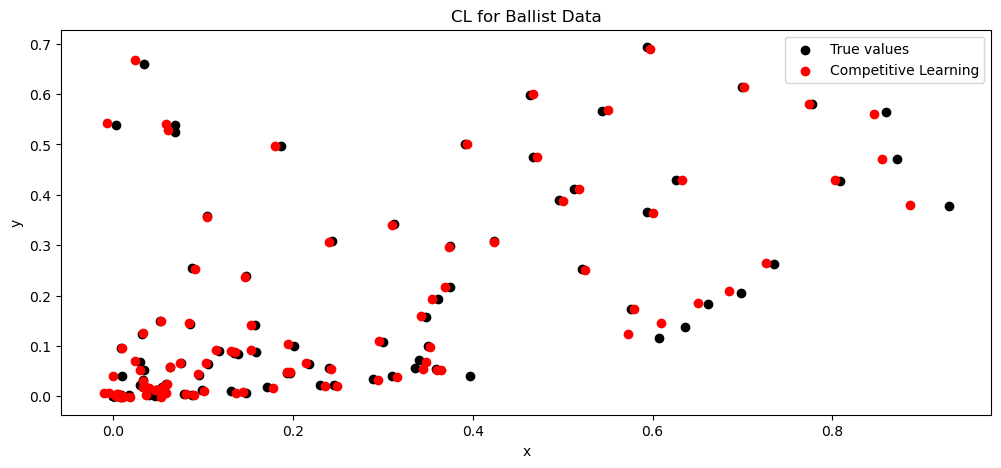

In [130]:
train_data = np.loadtxt("data_lab2/ballist.dat")
test_data = np.loadtxt("data_lab2/balltest.dat")
X_train, Y_train = train_data[:, :2], train_data[:, 2:]
X_test, Y_test = test_data[:, :2], test_data[:, 2:]

rbf_cl = RBFNN(node_number=18, sigma=0.5, eta=0.1, position=3)
rbf_cl.fit_batch(X_train, Y_train)
Y_pred_cl = rbf_cl.predict(X_test)
error_cl = np.mean(np.linalg.norm(Y_pred_cl - Y_test, axis=1))
print("Error CL:", error_cl)

plt.figure(figsize=(12, 5))
plt.scatter(Y_test[:, 0], Y_test[:, 1], label="True values", color="black")
plt.scatter(Y_pred_cl[:, 0], Y_pred_cl[:, 1], label="Competitive Learning", color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("CL for Ballist Data")
plt.show()